In [509]:
#update libs
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade inflect
!pip install --upgrade pprint
!pip install --upgrade seaborn
!pip install --upgrade contractions
!pip install --upgrade wordcloud
!pip install --upgrade umap-learn
!pip install --upgrade gensim
!pip install --upgrade pyldavis

Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.23.4)
Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.2)
Requirement already up-to-date: inflect in c:\anaconda\lib\site-packages (2.1.0)
Requirement already up-to-date: pprint in c:\anaconda\lib\site-packages (0.1)
Requirement already up-to-date: seaborn in c:\anaconda\lib\site-packages (0.9.0)
Requirement already up-to-date: contractions in c:\anaconda\lib\site-packages (0.0.17)
Requirement already up-to-date: wordcloud in c:\anaconda\lib\site-packages (1.5.0)
Requirement already up-to-date: umap-learn in c:\anaconda\lib\site-packages (0.3.7)
Requirement already up-to-date: gensim in c:\anaconda\lib\site-packages (3.7.0)


  Running setup.py bdist_wheel for pyldavis: started
  Running setup.py bdist_wheel for pyldavis: finished with status 'done'
  Stored in directory: C:\Users\chief\AppData\Local\pip\Cache\wheels\98\71\24\513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyldavis


In [155]:
#hdbscan test, not working import, what to do?
'''!pip install --upgrade PyHamcrest
!pip install --upgrade setuptools
!pip install --upgrade cython
!pip install --upgrade hdbscan
import setuptools
import cython
import hdbscan''';

'!pip install --upgrade PyHamcrest\n!pip install --upgrade setuptools\n!pip install --upgrade cython\n!pip install --upgrade hdbscan\nimport setuptools\nimport cython\nimport hdbscan'

In [156]:
#common libs
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns

import re
import string
import inflect
import itertools
from pprint import pprint
from tqdm import tqdm
import glob
import contractions
from wordcloud import WordCloud
import umap
import unicodedata
from bs4 import BeautifulSoup
from time import time
from itertools import compress

#from scipy import interp
sns.set(font_scale=1.3)

%matplotlib inline

In [510]:
#sklearn libs
from sklearn.preprocessing import label_binarize,MultiLabelBinarizer,StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline



from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.cluster import KMeans,DBSCAN

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split 
from sklearn.model_selection import KFold,RandomizedSearchCV, cross_val_score

from sklearn.metrics import recall_score, brier_score_loss,precision_score,f1_score
from sklearn.metrics import confusion_matrix, make_scorer, classification_report
from sklearn.metrics import homogeneity_score,completeness_score, v_measure_score
from sklearn.metrics import adjusted_rand_score,adjusted_mutual_info_score,silhouette_score

from sklearn.decomposition import PCA, TruncatedSVD,IncrementalPCA

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from gensim import matutils
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.sklearn

In [158]:
#npl libs
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('names')

from nltk.corpus import names
from nltk.corpus import stopwords
from nltk import ngrams

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer # one more stemmer? or lemmatisation
from nltk.stem import WordNetLemmatizer,LancasterStemmer

from sklearn.datasets import fetch_20newsgroups
seed = 321

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


Загрузим датасет с классифицируемыми текстами.

In [159]:
high_level_cat = ['alt', 'comp', 'misc', 'rec', 'sci', 'soc', 'talk']

In [160]:
# здесь shuffle = true, т.к. мы собираемся использовать SGDClassifier; Naive Bayes - они базируются на принципе iid данных 
#и чтобы не получить смещенную оценку
newsgroups_all = fetch_20newsgroups(subset='all', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
train_texts = fetch_20newsgroups(subset='train', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
test_texts = fetch_20newsgroups(subset='test', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))

Итак, задача данной работы:



#### EDA.

Посмотрим на данные, для этого:
- посмотрим на категории текстов
- распределение документов по категориям
- посмотрим на примеры данных

In [161]:
pprint("%d documents" % len(newsgroups_all.data))
pprint("%d categories" % len(newsgroups_all.target_names))

'18846 documents'
'20 categories'


In [162]:
newsgroups_all.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [163]:
def generate_stat_df(df,df_type):
    unique, counts = np.unique(df.target, return_counts=True)

    df_print = pd.DataFrame(data=list(zip(unique, df.target_names, counts)), 
                            columns = ['Id_category', 'Category_Name', 'N_texts'])
    df_print['High_level_topic'] = df_print["Category_Name"].str.split(".", expand = True)[0]
    df_print['Dataset_Type'] = df_type
    return df_print

df_summary = generate_stat_df(train_texts, 'train')
df_summary = df_summary.append(generate_stat_df(test_texts, 'test'), ignore_index=True)
df_summary = df_summary.append(generate_stat_df(newsgroups_all, 'all'), ignore_index=True)

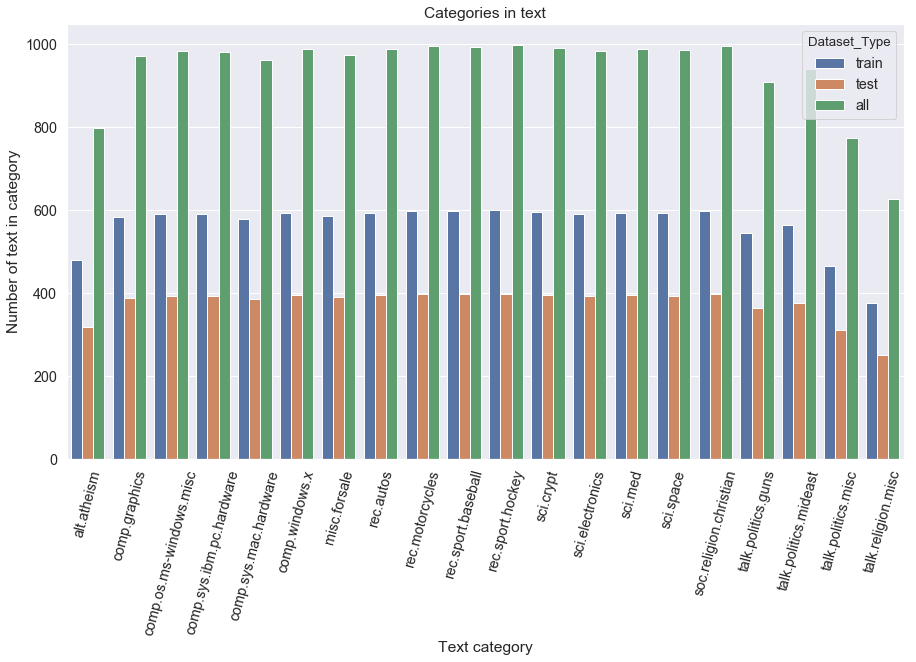

In [164]:
# print the histogramm with distribution of texts by categorieas and topics
plt.figure(figsize=(15,8))
sns.barplot(x="Category_Name", y="N_texts", hue = 'Dataset_Type',data=df_summary)
plt.xticks(rotation=75)
plt.xlabel('Text category');
plt.ylabel('Number of text in category');
plt.title("Categories in text");

                   0     1      2     3     4      5     6     7      8   \
High_level_topic  alt   alt    alt  comp  comp   comp  misc  misc   misc   
Dataset_Type      all  test  train   all  test  train   all  test  train   
N_texts           799   319    480  4891  1955   2936   975   390    585   

                    9   ...       11    12    13     14   15    16     17  \
High_level_topic   rec  ...      rec   sci   sci    sci  soc   soc    soc   
Dataset_Type       all  ...    train   all  test  train  all  test  train   
N_texts           3979  ...     2389  3952  1579   2373  997   398    599   

                    18    19     20  
High_level_topic  talk  talk   talk  
Dataset_Type       all  test  train  
N_texts           3253  1301   1952  

[3 rows x 21 columns]


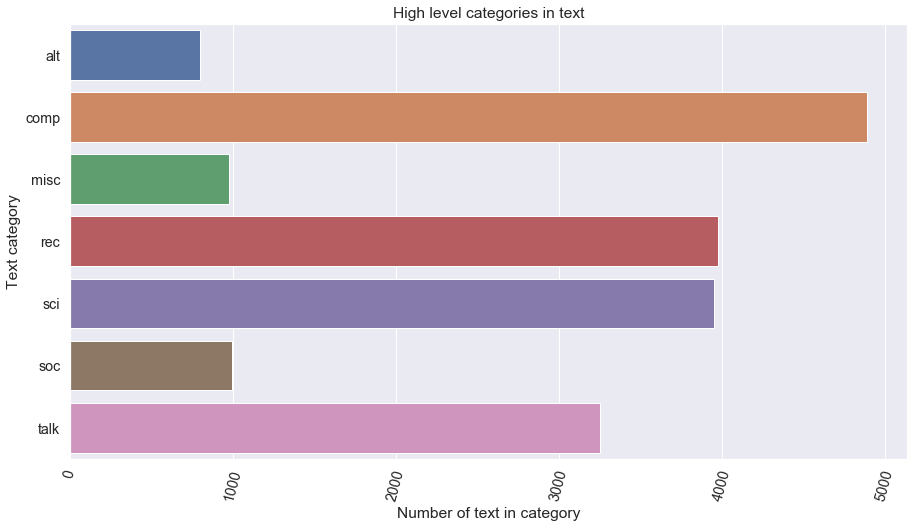

In [165]:
groupped_df = df_summary.groupby(['High_level_topic','Dataset_Type']).agg({'N_texts': ['sum']})
groupped_df.columns = groupped_df.columns.droplevel(1)
groupped_df.reset_index(inplace=True)
print(groupped_df.T)


plt.figure(figsize=(15,8))
sns.barplot(x="N_texts", y="High_level_topic", data=groupped_df[groupped_df.Dataset_Type == 'all'])
plt.xticks(rotation=75)
plt.xlabel('Number of text in category');
plt.ylabel('Text category');
plt.title("High level categories in text");

Посмотрим на образец данных.

In [166]:
pprint(newsgroups_all.data[11])

('\n'
 'This is a ridiculous argument for being a Christian.  So then, you might \n'
 'consider switching from Christianity to another religion if you were \n'
 'offered an even more frightening description of another hell?  How many\n'
 'Christians do think there are who view it strictly as an insurance policy?\n'
 'Not many I know; they believe in a message of love and compassion for \n'
 'others.  A faith based on fear of hell sounds like a dysfunctional \n'
 "relationship with God.  Like a child who cringes in fear of a parent's\n"
 'physical violence.  \n'
 '\n'
 'Many religions have concrete views of heaven and hell, with various\n'
 'threats and persuasions regarding who will go where.  Competition over\n'
 'who can envison the worst hell can hardly nurture the idea of loving\n'
 'your neighbor as yourself.\n'
 '\n')


In [167]:
newsgroups_all.target_names[newsgroups_all.target[11]]

'soc.religion.christian'

Текст содержит элементы вида - перенос строки, знаки препинания, имя собественное.

In [168]:
pprint(newsgroups_all.data[39])

('\n'
 '\n'
 "Again, you missed Jesus's point.  If you read the surrounding passages\n"
 'you would understand what Jesus means by "life in the world."  But\n'
 'as is, you bumbled around, asserted your standard axiom that the Bible is '
 'bunk,\n'
 'and came up with the wrong idea.  Also, you do not know exactly\n'
 'what Jesus means by eternal life.  \n'
 '\n'
 'Brian K., do you expect to jump in the middle of the quantum mechanics\n'
 'book and understand Hermite polynomials having not read the surrounding\n'
 'material?  Why do you such with the Bible?  For an idea what Jesus\n'
 'means by the world, look up references to it in your concordance.  For\n'
 'a good description, the whole Book of Ecclesiastes is game.  For \n'
 'eternal life, check out John 17:3, John 3:15-16.  You will find that\n'
 'eternal life is quite different than what you think.  Eternal life\n'
 'starts NOW--an infinitely high quality of life living in fellowship\n'
 'with God.\n'
 '\n'
 '\n'
 '\n'
 'If my die

In [169]:
newsgroups_all.target_names[newsgroups_all.target[39]]

'talk.religion.misc'

Помимо элементов из предыдущего текста здесь добавились ..., почтовый адрес и другие 'шумовые' элементы.

#### Data preprocessing.

Предобработаем данные, для этого:
- оставим только верхние категории текстов.

Созданим токенайзер, который будет:
- приведем все слова к нижнему регистру+.
- удалим знаки препинания+.
- заменим представление чисел в виде цифр на текстовые аналоги+.
- отсечем стоп слова (уберем символы и комбинации, которые не составляют смысловой нагрузки)+.
- проведем лемматизацию/стемминг (приведение слова к начальной форме с помощью словаря/выделение корня слова)+.
- удалим слова длиной 2 и менее символов+.
- выделим n-граммы (последовательности из нескольких слов, рассматриваемых как одно целое).

In [170]:
def preprocess_categories(text):
    #unique, counts = np.unique(text.target, return_counts=True)
    df_texts = pd.DataFrame(data=list(zip(text.data, text.target)),columns = ['data','category'])
    #remake this into better code!
    for i in df_texts.index:
        df_texts.ix[i, 'category'] = newsgroups_all.target_names[df_texts.at[i, 'category']];
        
    df_texts['target'] = df_texts["category"].str.split(".", expand = True)[0]
    
    df_texts.drop('category',inplace = True, axis = 1)

    return df_texts

In [171]:
train_texts = fetch_20newsgroups(subset='train', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
test_texts = fetch_20newsgroups(subset='test', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))

In [172]:
train_texts = preprocess_categories(train_texts);
test_texts = preprocess_categories(test_texts);

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [173]:
train_texts.shape

(11314, 2)

In [174]:
test_texts.shape

(7532, 2)

##### Tokenizer.

In [175]:
def remove_emails(text):
    text = re.sub('\S*@\S*\s?','',text)    
    return text

In [176]:
def remove_punctuation2(text_punctuation,text):
    
    new_text = []
    new_text = re.sub('['+text_punctuation+']', ' ',text)
    #new_text = re.sub('\n', ' ',new_text)
    #new_text = re.sub('\t', '',new_text)
    new_text =  new_text.strip()
    
    '''for word in text: 
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_word =  new_word.strip()
        new_text.append(new_word)'''
    
    return new_text


def remove_punctuation(text_punctuation,text):
    
    new_text = []
    #new_text = re.sub('['+text_punctuation+']', '',text)
    #new_text = re.sub('\n', ' ',new_text)
    for word in text: 
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_word =  new_word.strip()
        new_text.append(new_word)
    
    return new_text

In [177]:
def digits_to_text(text):
    p = inflect.engine()
    new_text = []
    for word in text:
        if word.isdigit():
            if len(word) > 18:
                print (1) #do nothing
            else:
                new_word = p.number_to_words(word)
                new_text.append(new_word)
        else:
            new_text.append(word)
    #del p
    return new_text

In [178]:
def lemmatize_stemm_text(text):
    new_text_lemma = []
    new_text_stemm = []
    
    lemmatizer = WordNetLemmatizer()
    stemmer = LancasterStemmer()
    
    for word in text:
        lemma = lemmatizer.lemmatize(word, pos='v') # pay attention to pos='v' parameter!
        new_text_lemma.append(lemma)
        
        stemm = stemmer.stem(word)
        new_text_stemm.append(stemm)
        
    return new_text_lemma, new_text_stemm
        

In [179]:
StopWords = list(set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS)))
newStopWords = ['jfc','jb'] # по ходу работы периодически добавляем стоп-слова
newStopWords2 = ['arent', 'didnt', 'doesnt', 'dont', 'hadnt', 'havent', 'isnt', 
                 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'theres','thatll', 'wasnt', 
                 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve',
                 "'ll", "'re", "'ve", "n't", 'need', 'sha', 'anna','n t','ann mari', 'ann marie', 
                 'anna diana', 'anna diane', 'anna maria', 'anne corinne', 'anne mar', 'anne marie', 
                 'barbara anne', 'bette ann', 'carol jean', 'diane marie', 'e lane', 'hans peter', 
                 'helen elizabeth', 'holly anne', 'jean christophe', 'jean francois', 'jean lou', 
                 'jean luc', 'jean marc', 'jean paul', 'jean pierre', 'jo anne', 'john david', 'john patrick', 
                 'kara lynn', 'marie ann', 'marie jeanne', 'paula grace', 'sara ann', 
                 'sheila kathryn', 'sue elle', 'terri jo', 'theresa marie', 'zsa',
                 '/       \\','0  w','0  w0','000','0000','000000','00000000', '0000000004',
                 '00000000b', '00000001', '00000001b', '00000010',
                 '00000010b', '00000011', '00000011b', '00000074',
                 '00000100', '00000100b', '00000101', '00000101b',
                 '00000110', '00000110b', '00000111', '00000111b',
                 '000005102000', '00001000', '00001000b',
                 '00001001', '00001001b', '00001010', '00001010b',
                 '00001011', '00001011b', '00001100', '00001100b', '00001101']

StopWords.extend(newStopWords)
StopWords.extend(newStopWords2)


male_names = names.words('male.txt')
female_names = names.words('female.txt')

Common_First_Names = list(set(male_names).union(set(female_names)))
Common_First_Names = list(map(lambda word: word.lower(), Common_First_Names))
# temporaly disabled to reduce tfidf time
#StopWords.extend(Common_First_Names) 

def remove_stopwords(stop_words ,text):
    
    new_words = []
    for word in text:
        if word not in stop_words:
            new_words.append(word)

    return new_words

In [180]:
def remove_short_words(text, word_len):
    new_text = []
    for word in text:
        if len(word) >= word_len:
            new_text.append(word)
            
    return new_text

In [181]:
#replace contractions in string of text
def replace_contractions(text):

    return contractions.fix(text)

In [182]:
#remove html constractions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [183]:
#remove non-ASCII characters from list of tokenized words"""
def remove_non_ascii(words):

    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [184]:
# getting source from string.punctuation
text_punctuation = '!"#$%&\'()*+,-.:;<=>?@[\\]_`{|}~/^'

def tokenize(text):
    min_length = 3
    
    # remove emails from text to prevent overfit
    text = remove_emails(text)
    
    #remove html 
    text = strip_html(text)
    
    #  text  to lowercase
    text =  text.lower()
    
    # test it
    text = replace_contractions(text)
    
    #remove punctuation
    text = remove_punctuation2(text_punctuation, text) 
    
    #ngrams test
    #words = list(ngrams(text.split(), 3))

    # tokenize text
    words = word_tokenize(text,language='english')
    
    #remove non ascii? test it
    words = remove_non_ascii(words)
    
    #remove punctuation
    #words = remove_punctuation(text_punctuation, words)   
    
    #replace digits with words
    #words = digits_to_text(words)
        
    # remove stopwords
    words = remove_stopwords(StopWords,words)
    
    #lemmatize words ,improve to 0.69 f1score
    words,_ = lemmatize_stemm_text(words)
    
    #stemm words 
    #_,words = lemmatize_stemm_text(words)
    
    #filter short words
    words = remove_short_words(words, 3)

    return words

In [185]:
%%time
test = tokenize(test_texts.data[4])

Wall time: 0 ns


In [186]:
test

[]

Проверим работу токенайзера на текстах.

In [187]:
pprint(newsgroups_all.data[10:15]) #1,3,55,39

['From: Center for Policy Research <cpr>\n'
 'Subject: Zionism - racism\n'
 '\n'
 '\n'
 "Diaspora 'a cancer'\n"
 '------------------- by Julian Kossoff and Lindsay Schusman in:\n'
 'Jewish Chronicle, London, 22. Dec. 1989\n'
 '\n'
 'Leading Israeli author and cultural commentator, A.B. Yehoshua,\n'
 'launched a ferocious attack on diaspora Jewry at a Zionist Youth\n'
 'Council meeting in North London, last week.\n'
 '\n'
 'The diaspora, he claimed, "was the cancer connected to the main\n'
 'tissue of the Jewish people". He was scathing about its failure to\n'
 'act before the Holocaust.\n'
 '\n'
 "He said the diaspora's religious and secular leadership had\n"
 'ignored the warning signs in the 1920s, and had fiercely opposed\n'
 'Zionism. Consequently, he considered the Holocaust, "the failure\n'
 'of Judaism".\n'
 '\n'
 'His talk, entitled "Diaspora: A Neurotic Solution", covered 5,000\n'
 'years of Jewish history.\n'
 '\n'
 "Mr. Yehoshua's other targets included Soviet Jews who were,

In [188]:
%%time
test = tokenize(newsgroups_all.data[10])
test4 = tokenize(newsgroups_all.data[44])
test5 = tokenize(newsgroups_all.data[55])
test6 = tokenize(newsgroups_all.data[66])
test7 = tokenize(newsgroups_all.data[77])

Wall time: 84.8 ms


In [189]:
test, test4, test6, test7,test5

(['center',
  'policy',
  'research',
  'subject',
  'zionism',
  'racism',
  'diaspora',
  'cancer',
  'julian',
  'kossoff',
  'lindsay',
  'schusman',
  'jewish',
  'chronicle',
  'london',
  'dec',
  '1989',
  'lead',
  'israeli',
  'author',
  'cultural',
  'commentator',
  'yehoshua',
  'launch',
  'ferocious',
  'attack',
  'diaspora',
  'jewry',
  'zionist',
  'youth',
  'council',
  'meet',
  'north',
  'london',
  'week',
  'diaspora',
  'claim',
  'cancer',
  'connect',
  'main',
  'tissue',
  'jewish',
  'people',
  'scathing',
  'failure',
  'act',
  'holocaust',
  'say',
  'diaspora',
  'religious',
  'secular',
  'leadership',
  'ignore',
  'warn',
  'sign',
  '1920s',
  'fiercely',
  'oppose',
  'zionism',
  'consequently',
  'consider',
  'holocaust',
  'failure',
  'judaism',
  'talk',
  'entitle',
  'diaspora',
  'neurotic',
  'solution',
  'cover',
  'years',
  'jewish',
  'history',
  'yehoshua',
  'target',
  'include',
  'soviet',
  'jews',
  'say',
  'stay',
  '

#### Classification. Apriory knoweledge.

После того, как проверили работу токенизатора, извлечем фичи из текста с использованием TF-IDF.

In [190]:
#backup params
'''vectorizer = TfidfVectorizer(stop_words=StopWords,
                             tokenizer=tokenize, 
                             #min_df=2, # ignore terms with freq less that т, lower majoring
                             #max_df=0.7, # ignore terms with freq more that n, upper majoring
                             max_features=100000,
                             use_idf=True,  
                             sublinear_tf=True,
                             norm='l2',
                             #ngram_range= (1, 3) temporaly disable
                            )''';

In [191]:
vectorizer = TfidfVectorizer(stop_words=StopWords,
                             tokenizer=tokenize, 
                             min_df=4, # ignore terms with freq less that т, lower majoring
                             max_df=0.8, # ignore terms with freq more that n, upper majoring
                             #max_features=100000,
                             use_idf=True,  
                             sublinear_tf=True,
                             norm='l2',
                             #ngram_range= (1, 3) temporaly disable
                            )

In [192]:
%%time
vectorizer.fit(train_texts.data)

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ann', 'anne', 'barbara', 'bette', 'carol', 'christophe', 'corinne', 'david', 'diana', 'diane', 'elizabeth', 'elle', 'francois', 'grace', 'hans', 'helen', 'holly', 'jean', 'jeanne', 'john', 'kara', 'kathryn', 'lane', 'lou', 'luc', 'lynn', 'mar', 'marc', 'mari', 'maria', 'marie', 'patrick', 'paul', 'paula', 'peter', 'pierre', 'sara', 'shall', 'sheila', 'sue', 'terri', 'theresa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Anaconda\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Wall time: 1min 28s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=4,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['con', 'always', 'itself', 'within', 'herself', 'otherwise', 'weren', 'around', "didn't", 'nevertheless', "should've", 'one', 'for', "don't", 't', 'was', 'don', 'it', 'nine', 'couldnt', 'last', 'six', 'this', 'doing', 'won', 'everywhere', 'bill', 'i', 'less', 'though', 'while', 'except',... '00001001b', '00001010', '00001010b', '00001011', '00001011b', '00001100', '00001100b', '00001101'],
        strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x00000242224B4488>, use_idf=True,
        vocabulary=None)

In [193]:
%%time
vectorised_train_documents = vectorizer.transform(train_texts.data)
vectorised_test_documents = vectorizer.transform(test_texts.data)

C:\Anaconda\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Wall time: 2min 25s


В силу того, что после извлечения фич могут получиться пустые тексты (например из-за отсечения стоп слов, по длине слова и т.д.), то есть смысл эти строки отфильтровать, чтобы улучшить качество классификации.

In [194]:
def get_empty_rows(sprs_matrix):
    #list_ind = []
    empty_indecies_marker = sprs_matrix.getnnz(1)>0
    '''for i in range(len(empty_indecies_marker)):
        if empty_indecies_marker[i] == False:
            list_ind.append(i)'''
    
    return empty_indecies_marker

Также не стоит забывать про обновление массивов с метками классов, для этого сохраним их индексы.

In [195]:
ind_train_to_drop = get_empty_rows(vectorised_train_documents)
ind_test_to_drop = get_empty_rows(vectorised_test_documents)

In [196]:
vectorised_train_documents.shape #before

(11314, 15819)

In [197]:
vectorised_test_documents.shape #before

(7532, 15819)

In [198]:
#vectorised_test_documents.sum(axis=1)
vectorised_train_documents = vectorised_train_documents[vectorised_train_documents.getnnz(1)>0]
vectorised_test_documents = vectorised_test_documents[vectorised_test_documents.getnnz(1)>0]

In [199]:
vectorised_train_documents.shape #after!

(10975, 15819)

In [200]:
vectorised_test_documents.shape #after!

(7288, 15819)

In [201]:
len(vectorizer.get_feature_names())

15819

Как видно, такие строки были и не в единичном количестве.

Выделим метки для трейн/тест датасетов.

In [202]:
y_train, y_test = train_texts.target, test_texts.target

In [203]:
len(y_train)

11314

In [204]:
len(y_test)

7532

Также обновим метки классов, после удаления пустых строк, оставшихся после векторизации.

In [205]:
#y_train
y_train = list(compress(y_train, ind_train_to_drop))
y_test = list(compress(y_test, ind_test_to_drop))

In [206]:
len(y_train)

10975

In [207]:
len(y_test)

7288

Дополним код вспомогательными функциями, которые будет производить:
- построение матрицы классификации.
- обучение и проверку работы классификатора, с заданными параметрами.

In [208]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Paired):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [209]:
#simple variant
def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    clf = classifier
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='weighted')

    #print ("Test score")
    pred_test = clf.predict(X_test)
    f1_test = f1_score(y_test, pred_test, average='weighted')
    
    return f1_train, f1_test, clf

Для удобства, результирующие метрики будем сохранять в df.

In [210]:
results_df = []
results_df = pd.DataFrame(columns=('Algorithm', 'Train_score', 'Test_score', 'parameters'))

In [211]:
#variant with pipeline and cv
#takes a long and boooring time
'''def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    tfidf_params = {
        'stop_words' : StopWords,
        'tokenizer':tokenize,
        'use_idf':True,
        'sublinear_tf':True,
        'norm':'l2'
    }
    clf = Pipeline([('vect', TfidfVectorizer(** tfidf_params)), ('classifier', classifier)])
    
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='micro')

    #print ("Test score")
    #pred_test = clf.predict(X_test)
    #f1_test = f1_score(y_test, pred_test, average='micro')
    
    my_scorer = make_scorer(f1_score, average='weighted')
    skv = StratifiedKFold(n_splits = 3,random_state=seed, shuffle=True)
    f1_test = cross_val_score(clf, X_test, y_test, cv=skv, scoring=my_scorer,n_jobs = -1).mean()
    
    return f1_train, f1_test


alphas = [0.01 , 0.015, 0.02]

for alph in tqdm(alphas):
    a = "MultinomialNB"
    b,c = classify_and_score(MultinomialNB(alpha=alph), train_texts.data, 
                           test_texts.data, y_train, y_test)
    d = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':a, 'Train_score':b,'Test_score':c, 'parameters':d},ignore_index=True)
    
    ''';

Проверим работу алгоритмов:
- MultinomialNB

In [212]:
#actual block of code
alphas = [0.0001,0.001,0.005 ,0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,2,5]

for alph in tqdm(alphas):
    f_el = "MultinomialNB"
    s_el,t_el,_ = classify_and_score(MultinomialNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

 98%|████████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:02<00:00, 17.81it/s]C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 18.02it/s]


- BernoulliNB

In [213]:
for alph in tqdm(alphas):
    f_el = "BernoulliNB"
    s_el,t_el,_ = classify_and_score(BernoulliNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 12.36it/s]


Для проверки результатов выведем classification_report и построим матрицу классификации.

- LinearSVC

In [214]:
%%time
linear_svc = LinearSVC(random_state=seed,max_iter = 10e3,class_weight = 'balanced',loss = 'squared_hinge',dual=False)
C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.9, 1.0, 2.0, 5.0, 10.0, 20.0]
penalties = ['l1','l2']

for pn in tqdm(penalties):
    linear_svc.penalty  = pn
    for c in tqdm(C_values):
        f_el = "LinearSVC"
        linear_svc.C = c
        s_el,t_el,_ = classify_and_score(linear_svc, vectorised_train_documents, 
                               vectorised_test_documents, y_train, y_test)
        f0_el = "C = " + str(c) + " penalty = " + pn

        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:22<00:00, 92.88s/it]


Wall time: 2min 22s


- SVC Kernel Poly

Известно, что метод опорных векторов чувствителен к выбору ядра и их параметров, то действовать скорее всего буду следующим образом, запуск алгоритма с дефолтными параметрами и если скор низкий, переходить к другому ядру.

Т.к. алгоритм требует достаточно большое время на выполнение, то ограничим перебор несколькими значениями параметра С.

In [61]:
%%time

svc_poly = SVC(kernel='poly',gamma='scale',random_state=seed,class_weight = 'balanced')

svc_poly.C = 0.5
svc_poly.kernel = 'poly'
f_el = "SVC_" + svc_poly.kernel
s_el,t_el,_ = classify_and_score(svc_poly,vectorised_train_documents, vectorised_test_documents, y_train, y_test)
f0_el = "C = " + str(svc_poly.C) + " Kernel = " + svc_poly.kernel

results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

'''
#C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 2.0, 5.0, 10.0, 20.0]
C_values_reduced = [0.001, 0.01, 0.5]

for c in tqdm(C_values_reduced):
    f_el = "SVC_poly"
    svc_poly.C = c
    s_el,t_el,_ = classify_and_score(svc_poly, vectorised_train_documents, vectorised_test_documents, y_train, y_test)
    f0_el = "C = " + str(c)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)'''

NameError: name 'svc_k' is not defined

- SVC Kernel Sigmoid and RBF

In [74]:
%%time

svc_k = SVC(kernel='sigmoid',gamma='scale',random_state=seed,class_weight = 'balanced',verbose=True)

svc_k.C = 0.5
svc_k.kernel = 'sigmoid'
f_el = "SVC_" + svc_k.kernel
s_el,t_el,_ = classify_and_score(svc_k,vectorised_train_documents, vectorised_test_documents, y_train, y_test)
f0_el = "C = " + str(svc_k.C) + " Kernel = " + svc_k.kernel

results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                'Test_score':t_el, 'parameters':f0_el},ignore_index=True)


svc_k.C = 0.5
svc_k.kernel = 'rbf'
f_el = "SVC_" + svc_k.kernel
s_el,t_el,_ = classify_and_score(svc_k,vectorised_train_documents, vectorised_test_documents, y_train, y_test)
f0_el = "C = " + str(svc_k.C) + " Kernel = " + svc_k.kernel

results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

'''
kernels = ['rbf','sigmoid']
C_values_reduced = [0.001, 0.01, 0.5, 1.0, 5.0]

for kern in tqdm(kernels):
    svc_k.kernel = kern
    for c in tqdm(C_values_reduced):
        svc_k.C = c
        f_el = "SVC_" + kern
        s_el,t_el,_ = classify_and_score(svc_k,vectorised_train_documents, vectorised_test_documents, y_train, y_test)
        f0_el = "C = " + str(c) + " Kernel = " + kern

        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score':t_el, 'parameters':f0_el},ignore_index=True)'''

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=321,
  shrinking=True, tol=0.001, verbose=False)


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.05048780996626344 0.05160507064784775
Wall time: 3min 21s


- SGDClassifier.

In [215]:
sgd_clf = SGDClassifier(loss = 'modified_huber', penalty = 'l2',
                        alpha = 0.0001, l1_ratio = 0.01,
                        max_iter = 1000, tol = 1e-4,
                        n_jobs = -1, random_state = seed,
                        learning_rate = 'optimal', #adaptive - no profit
                        class_weight = 'balanced', shuffle = True,
                        n_iter_no_change = 100, early_stopping = True
             )

In [216]:
losses = ['hinge','log','modified_huber','squared_hinge','perceptron']
penalties = ['l1','l2','elasticnet']
alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 3, 5]

for ls in tqdm(losses):
    f_el = "SGD"
    sgd_clf.loss = ls
    s_el,t_el,_ = classify_and_score(sgd_clf, vectorised_train_documents, 
                                     vectorised_test_documents, y_train, y_test)
    f0_el = "loss = " + ls
    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.79s/it]


In [217]:
results_df.tail(n=15)

,Algorithm,Train_score,Test_score,parameters
120,LinearSVC,0.970469,0.808943,C = 0.3 penalty = l2
121,LinearSVC,0.976832,0.808922,C = 0.4 penalty = l2
122,LinearSVC,0.981907,0.807224,C = 0.5 penalty = l2
123,LinearSVC,0.984994,0.806861,C = 0.6 penalty = l2
124,LinearSVC,0.992535,0.803508,C = 0.9 penalty = l2
125,LinearSVC,0.994264,0.803196,C = 1.0 penalty = l2
126,LinearSVC,0.997451,0.795455,C = 2.0 penalty = l2
127,LinearSVC,0.998725,0.783974,C = 5.0 penalty = l2
128,LinearSVC,0.998725,0.777139,C = 10.0 penalty = l2
129,LinearSVC,0.998907,0.773067,C = 20.0 penalty = l2


Как видно из результатов, лучше всего работает функция потерь:

In [218]:
sgd_clf.loss = 'hinge'
sgd_clf

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.01, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=100, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=321, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False)

Попробуем подобрать для нее оптимальный параметр регуляризации:

In [219]:
for alp in tqdm(alphas):
    sgd_clf.alpha = alp
    f_el = "SGD"
    s_el,t_el,_ = classify_and_score(sgd_clf, vectorised_train_documents,
                                     vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alp)
    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

 38%|███████████████████████████████▌                                                    | 3/8 [00:04<00:07,  1.56s/it]C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 50%|██████████████████████████████████████████                                          | 4/8 [00:06<00:06,  1.57s/it]C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-

In [220]:
#attempt of elastic net

'''alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 3, 5]
l1_ratios = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9]

for alp in tqdm(alphas):
    sgd_clf.alpha = alp
    for l1 in tqdm(l1_ratios):
        f_el = "SGD"
        sgd_clf.l1_ratio = l1
        s_el,t_el,_ = classify_and_score(sgd_clf, vectorised_train_documents, 
                                         vectorised_test_documents, y_train, y_test)
        f0_el = "alpha = " + str(alp) + " l1_ratio = " + str(l1)
        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score':t_el, 'parameters':f0_el},ignore_index=True)''';
# compare hinge loss == linear SVM
# compare other different kernels

Возвращаем обратно параметр alpha.

In [221]:
sgd_clf.alpha = 0.0001
sgd_clf

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.01, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=100, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=321, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False)

GaussianNB не использовался, т.к. на вход этому алгоритму требуется dense, а не sparce-матрица.
При выполнении преобразования todense()/toarray() потребление памяти существенно возрастает и приводит к тому, что массив не помещяется в память.

In [222]:
"""clf = GaussianNB()
clf.fit(vectorised_train_documents.toarray(), y_train)
pred = clf.predict(vectorised_test_documents.toarray())
f1_score(y_test, pred, average='micro')""";

Попробуем визуализировать скор алгоритмов, для того, чтобы визуально оценить их работу.

In [223]:
#sns.lineplot(x=results_df.Test_score, hue="Algorithm", lw=1, data=results_df)
#ax = sns.lineplot(y = 'Test_score',data = results_df)
#sns.lineplot(x = results_df.Test_score,data = results_df)
#plt.plot(results_df[results_df.Algorithm == 'SVC_poly']['Test_score'])

In [224]:
def get_top_n_words(clf, vectorizer, n):
    # improve for most not used words too
    for cls in range(len(clf.coef_)):
        print (cls, labels[cls])
        neg_class_prob_sorted = clf.coef_[cls, :].argsort()[::1] #1 ascending order #-1 descending order
        pos_class_prob_sorted = clf.coef_[cls, :].argsort()[::-1] 
        print ("most informative features")
        print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:n]))
        print ("less informative features")
        print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:n]))

Выведем 3 алгоритма с наилучшими результатами.

In [225]:
print(
results_df.iloc[results_df[results_df.Algorithm =='MultinomialNB']['Test_score'].idxmax()],'\n',
results_df.iloc[results_df[results_df.Algorithm =='LinearSVC']['Test_score'].idxmax()],'\n',
results_df.iloc[results_df[results_df.Algorithm =='SGD']['Test_score'].idxmax()]
)

Algorithm      MultinomialNB
Train_score         0.940046
Test_score           0.81262
parameters      alpha = 0.04
Name: 9, dtype: object 
 Algorithm                 LinearSVC
Train_score                0.958491
Test_score                  0.80913
parameters     C = 0.2 penalty = l2
Name: 119, dtype: object 
 Algorithm             SGD
Train_score      0.919571
Test_score       0.801985
parameters     loss = log
Name: 131, dtype: object


Выведем матрицу классификации и топ слов для каждого из этих алгоритмов.

##### MultinomialNB.

              precision    recall  f1-score   support

         alt       0.75      0.40      0.52       310
        comp       0.85      0.91      0.88      1906
        misc       0.86      0.61      0.71       382
         rec       0.89      0.88      0.89      1521
         sci       0.79      0.79      0.79      1518
         soc       0.69      0.78      0.73       384
        talk       0.75      0.81      0.78      1267

   micro avg       0.82      0.82      0.82      7288
   macro avg       0.80      0.74      0.76      7288
weighted avg       0.82      0.82      0.81      7288

Confusion matrix, without normalization
None


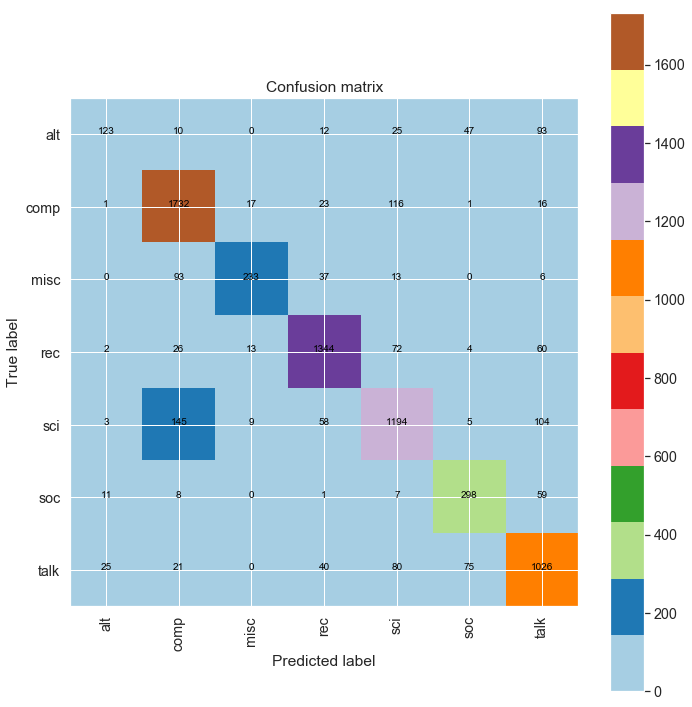

In [226]:
_,_,clf =  classify_and_score(MultinomialNB(alpha = 0.04), vectorised_train_documents, 
                                        vectorised_test_documents, y_train, y_test)

labels = clf.classes_
pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,labels = labels))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = labels))


In [227]:
get_top_n_words(clf,vectorizer,10)

0 alt
most informative features
['say' 'god' 'think' 'people' 'atheism' 'religion' 'post' 'know' 'mean'
 'believe']
less informative features
['0001' 'minerals' 'miners' 'mini' 'miniature' 'minimally' 'minimize'
 'miniscribe' 'miniscule' 'minister']
1 comp
most informative features
['use' 'thank' 'windows' 'file' 'know' 'card' 'work' 'program' 'problem'
 'run']
less informative features
['tamper' 'heinrich' 'heinous' 'heel' 'hee' 'hedican' 'hebrews' 'hebrew'
 'successes' 'heavenly']
2 misc
most informative features
['sale' 'offer' 'sell' 'ship' 'include' 'condition' 'new' 'price' 'email'
 'mail']
less informative features
['0001' 'mortgage' 'mos' 'mosaic' 'moses' 'moslem' 'moslems' 'mosque'
 'mosques' 'moss']
3 rec
most informative features
['game' 'team' 'think' 'car' 'like' 'bike' 'year' 'play' 'know' 'good']
less informative features
['interleave' 'kratz' 'krillean' 'krishna' 'ksc' 'kuiper' 'kurd' 'kosmos'
 'kurdish' 'kuwait']
4 sci
most informative features
['use' 'know' 'key' 'lik

##### SGD Classifier.

In [228]:
sgd_clf

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.01, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=100, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=321, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [229]:
_,_,clf =  classify_and_score(sgd_clf, vectorised_train_documents, 
                                        vectorised_test_documents, y_train, y_test)

              precision    recall  f1-score   support

         alt       0.44      0.48      0.46       310
        comp       0.87      0.89      0.88      1906
        misc       0.71      0.79      0.75       382
         rec       0.87      0.87      0.87      1521
         sci       0.83      0.75      0.78      1518
         soc       0.59      0.78      0.67       384
        talk       0.78      0.73      0.75      1267

   micro avg       0.80      0.80      0.80      7288
   macro avg       0.73      0.76      0.74      7288
weighted avg       0.80      0.80      0.80      7288

Confusion matrix, without normalization
None


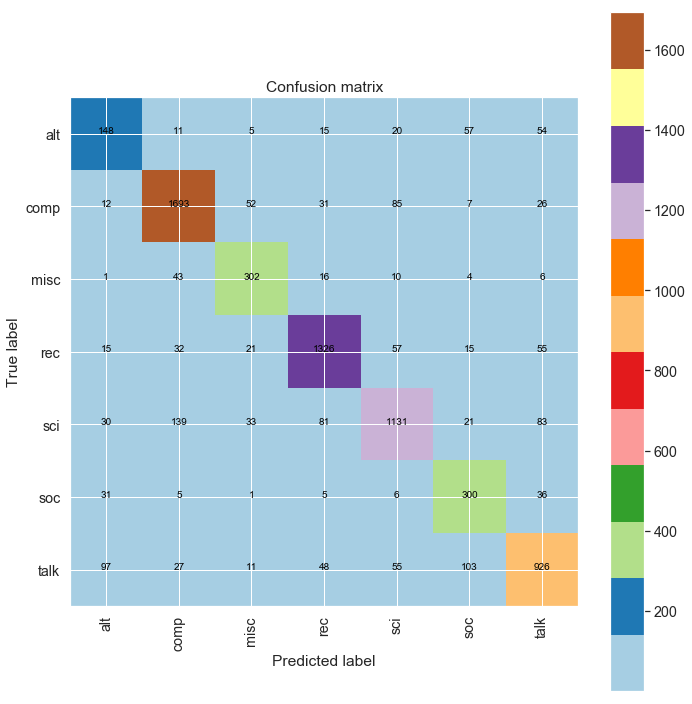

In [230]:
pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,labels = labels))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = labels))

In [231]:
get_top_n_words(clf, vectorizer, 10)

0 alt
most informative features
['motto' 'atheism' 'nanci' 'religion' 'enlighten' 'loan' 'bsa' 'bobby'
 'islamic' 'cruel']
less informative features
['christians' 'christ' 'scripture' 'want' 'play' 'truth' 'order' 'judaism'
 'heaven' 'christian']
1 comp
most informative features
['windows' 'graphics' 'mac' 'apple' 'problem' 'window' 'image' 'motif'
 'file' 'widget']
less informative features
['sale' 'offer' 'circuit' 'car' 'pgp' 'sell' 'brand' 'ship' 'items'
 'condition']
2 misc
most informative features
['sale' 'ship' 'offer' 'headline' 'forsale' 'tracy' 'sell' 'new'
 'refrigerator' 'miller']
less informative features
['help' 'wonder' 'appreciate' 'dealer' 'comment' 'remember' 'data'
 'problem' 'saw' 'question']
3 rec
most informative features
['bike' 'car' 'motorcycle' 'team' 'dod' 'cars' 'hockey' 'helmet'
 'baseball' 'sport']
less informative features
['gun' 'work' 'space' 'offer' 'cassette' 'health' 'government' 'use'
 'computer' 'house']
4 sci
most informative features
['space' 'c

In [232]:
linear_svc = LinearSVC(random_state=seed,max_iter = 10e3,class_weight = 'balanced',loss = 'squared_hinge',dual=False)
linear_svc.penalty  = 'l2'
linear_svc.C = 0.4

#### Linear SVC.

In [233]:
linear_svc

LinearSVC(C=0.4, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000.0,
     multi_class='ovr', penalty='l2', random_state=321, tol=0.0001,
     verbose=0)

In [234]:
_,_,clf =  classify_and_score(linear_svc, vectorised_train_documents, 
                                        vectorised_test_documents, y_train, y_test)

              precision    recall  f1-score   support

         alt       0.49      0.48      0.48       310
        comp       0.88      0.89      0.88      1906
        misc       0.76      0.79      0.77       382
         rec       0.87      0.88      0.87      1521
         sci       0.82      0.76      0.79      1518
         soc       0.64      0.78      0.71       384
        talk       0.78      0.75      0.77      1267

   micro avg       0.81      0.81      0.81      7288
   macro avg       0.75      0.76      0.75      7288
weighted avg       0.81      0.81      0.81      7288

Confusion matrix, without normalization
None


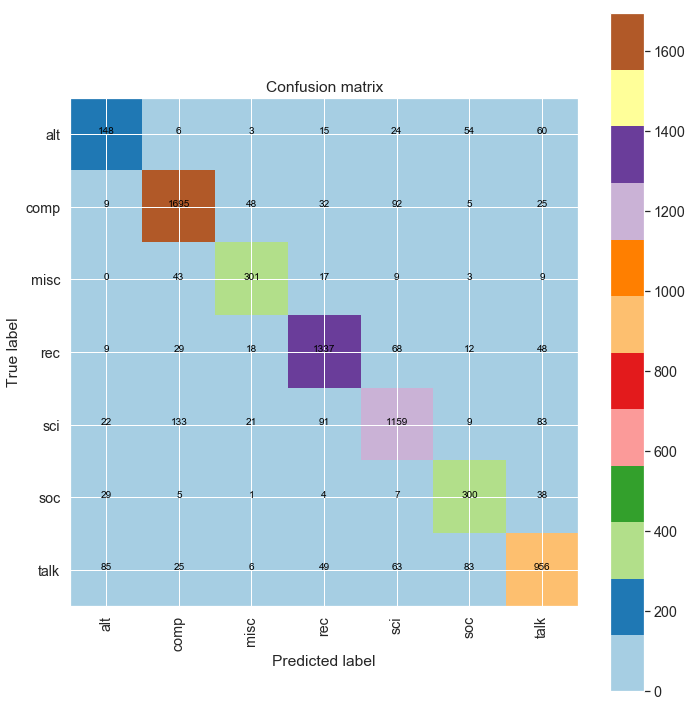

In [235]:
pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,labels = labels))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = labels))

In [236]:
get_top_n_words(clf, vectorizer, 10)

0 alt
most informative features
['atheism' 'motto' 'religion' 'bobby' 'nanci' 'islamic' 'islam' 'atheists'
 'deletion' 'loan']
less informative features
['christians' 'christ' 'scripture' 'want' 'order' 'heaven' 'judaism'
 'children' 'friend' 'christian']
1 comp
most informative features
['windows' 'graphics' 'mac' 'motif' 'problem' 'apple' 'image' 'file'
 'window' 'powerbook']
less informative features
['sale' 'offer' 'car' 'circuit' 'pgp' 'manuals' 'game' 'sell' 'years'
 'team']
2 misc
most informative features
['sale' 'offer' 'ship' 'sell' 'include' 'forsale' 'condition' 'summer'
 'headline' 'postage']
less informative features
['help' 'read' 'appreciate' 'hear' 'tell' 'wonder' 'program' 'connect'
 'problem' 'remember']
3 rec
most informative features
['car' 'bike' 'team' 'motorcycle' 'dod' 'cars' 'hockey' 'helmet'
 'baseball' 'players']
less informative features
['gun' 'space' 'offer' 'government' 'use' 'card' 'work' 'program' 'file'
 'house']
4 sci
most informative features
['spac

In [ ]:
#backup results
results_df.to_csv("results_df.csv", sep=';', encoding='utf-8',index = False, header = True)

#### Classfication. Without apriory knoweledge.

Your task is to cluster news without prior knowing of original labels. 
And then evaluate performance of your clustering approach: 
1) using original labels 
2) without prior knowledge of labels.

You also may use dimension reduction techniques for visualization purposes, which can give you some insights about data structure.

Scoring:

1) EDA - 2

Text length histogram, words cloud, whatever...
Dimension reduction and visualization
TruncatedSVD
T-SNE or UMAP.

2) Clustering - 3

K-means or MiniBatchKMeans
DBSCAN or HDBSCANС.

3) Performance evaluation -2.

With prior knowledge of ground truth
At least V-measure and adjusted mutual information

Without prior knowledge of ground truth
At least silhouette coefficient
4) Topic modeling - 2

Understand what's the difference between clustering, dimension reduction and topic modeling
Try to use LDA Ссылки на внешний сайт.from Gensim and pyLDAvisСсылки на внешний сайт. for visualization

В этом разделе попробуем классифицировать объекты без знания о принадлежности текстов к какому-либо классу.
Для этого:
- попробуем посмотреть на тексты без знания(EDA), об их принадлежности классам.
- сократим размерность (TruncatedSVD)  и попробуем визуализировать структуру данных (T-SNE or UMAP).  
- Попробуем выделить классы при помощи K-means or MiniBatchKMeans;DBSCAN or HDBSCANС.

#### EDA.
Для того, чтобы оценить как-то текст, без знания меток классов:
- посчитаем общее количество текстов, построим гистограмму длин текстов, boxplot'ы длин текстов.
- сколько слов во всех текстах, среднее число слов на 1 текст.
- выделим топ-20 слов по всем текстам и построим их гистограмму частот.
- построим облако слов. (по мнению CountVectorizer и TfIdfVectorizer).


- построим гистограмму: количество слов - длина слова
- Еще график с зависимостью количества слов от его длины./просто посчитать символ-частота?


- посчитаем общее количество текстов, построим гистограмму длин текстов, boxplot'ы длин текстов.

In [237]:
print (len(train_texts.data),';',len(test_texts.data))

11314 ; 7532


In [238]:
df_texts = pd.DataFrame(data=train_texts.data.values,columns = ['text'])#, 'text_type'])

df_texts['text_type'] = 'train'

df_texts = df_texts.append(pd.DataFrame(data=test_texts.data.values,columns = ['text']), ignore_index=True,sort=False)

df_texts.fillna(value='test',inplace=True)

df_texts['text_len'] = df_texts.text.str.len()

df_texts['n_words'] = df_texts.text.str.split()

df_texts['n_words'] = df_texts.n_words.str.len()

#df_texts.head()

print (pd.concat([df_texts[df_texts.text_type == 'train'].describe(),
                  df_texts[df_texts.text_type == 'test'].describe()], axis=1))

# count words in train
df_texts[df_texts.text_type == 'train'].n_words.sum()
# count words in test
df_texts[df_texts.text_type == 'test'].n_words.sum()

           text_len       n_words       text_len      n_words
count  11314.000000  11314.000000    7532.000000  7532.000000
mean    1218.135496    185.827382    1096.862586   175.344397
std     4038.256477    523.971647    3571.221784   465.226887
min        0.000000      0.000000       0.000000     0.000000
25%      237.000000     40.000000     230.000000    39.000000
50%      491.000000     83.000000     483.500000    82.000000
75%      984.750000    167.000000     967.250000   163.000000
max    74878.000000  11765.000000  158791.000000  9507.000000


1320694

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


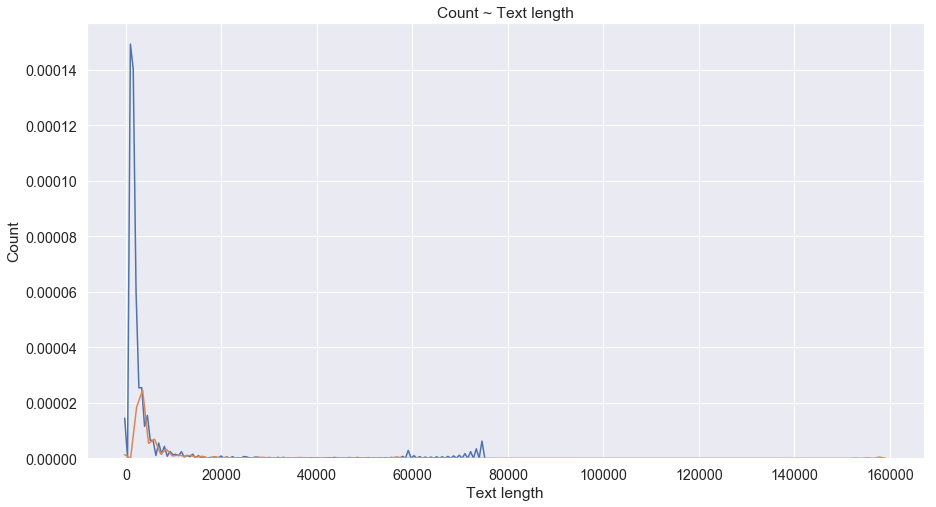

In [239]:
plt.figure(figsize=(15,8))
sns.distplot(df_texts[df_texts.text_type == 'train'].text_len,hist = False)
sns.distplot(df_texts[df_texts.text_type == 'test'].text_len,hist = False)
plt.xlabel('Text length');
plt.ylabel('Count');
plt.title("Count ~ Text length");

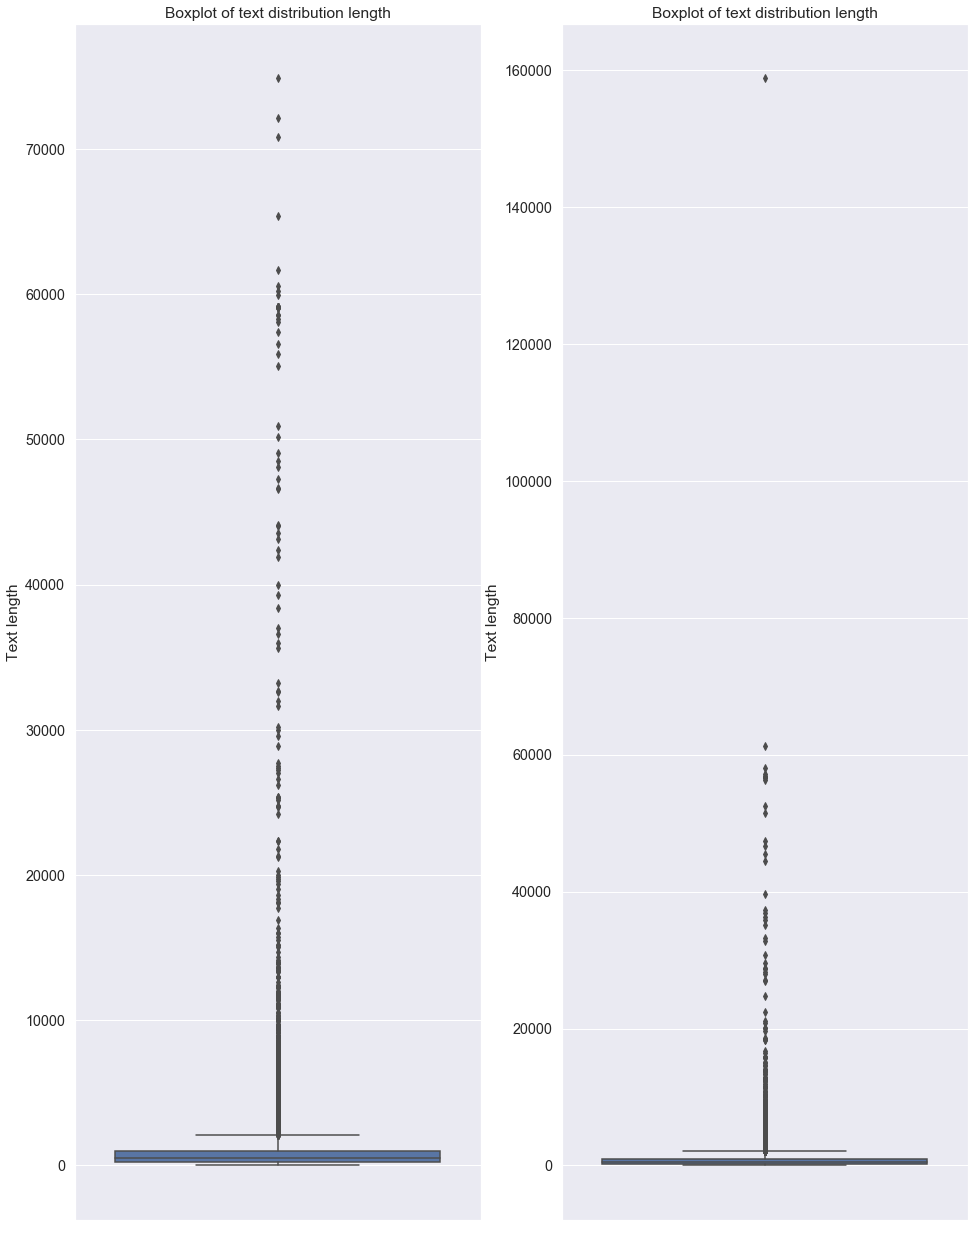

In [240]:
plt.figure(figsize=(16,22))
plt.subplot(1,2,1)
sns.boxplot(y = df_texts[df_texts.text_type == 'train'].text_len)
plt.ylabel('Text length');
plt.title("Boxplot of text distribution length");
plt.subplot(1,2,2)
sns.boxplot(y = df_texts[df_texts.text_type == 'test'].text_len)
plt.ylabel('Text length');
plt.title("Boxplot of text distribution length");
plt.show();

- Выделим топ-20 слов по всем текстам и построим их гистограмму частот.

Считаем через count_vectorizer, потому что to_array c tf-idf падает с memory error.(fixed).

In [241]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(tokenizer=tokenize, 
                          stop_words=StopWords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [242]:
%%time
train_top_words = get_top_n_words(train_texts.data, n=150);
test_top_words = get_top_n_words(test_texts.data, n=150);

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ann', 'anne', 'barbara', 'bette', 'carol', 'christophe', 'corinne', 'david', 'diana', 'diane', 'elizabeth', 'elle', 'francois', 'grace', 'hans', 'helen', 'holly', 'jean', 'jeanne', 'john', 'kara', 'kathryn', 'lane', 'lou', 'luc', 'lynn', 'mar', 'marc', 'mari', 'maria', 'marie', 'patrick', 'paul', 'paula', 'peter', 'pierre', 'sara', 'shall', 'sheila', 'sue', 'terri', 'theresa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Anaconda\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass t

Wall time: 5min 35s


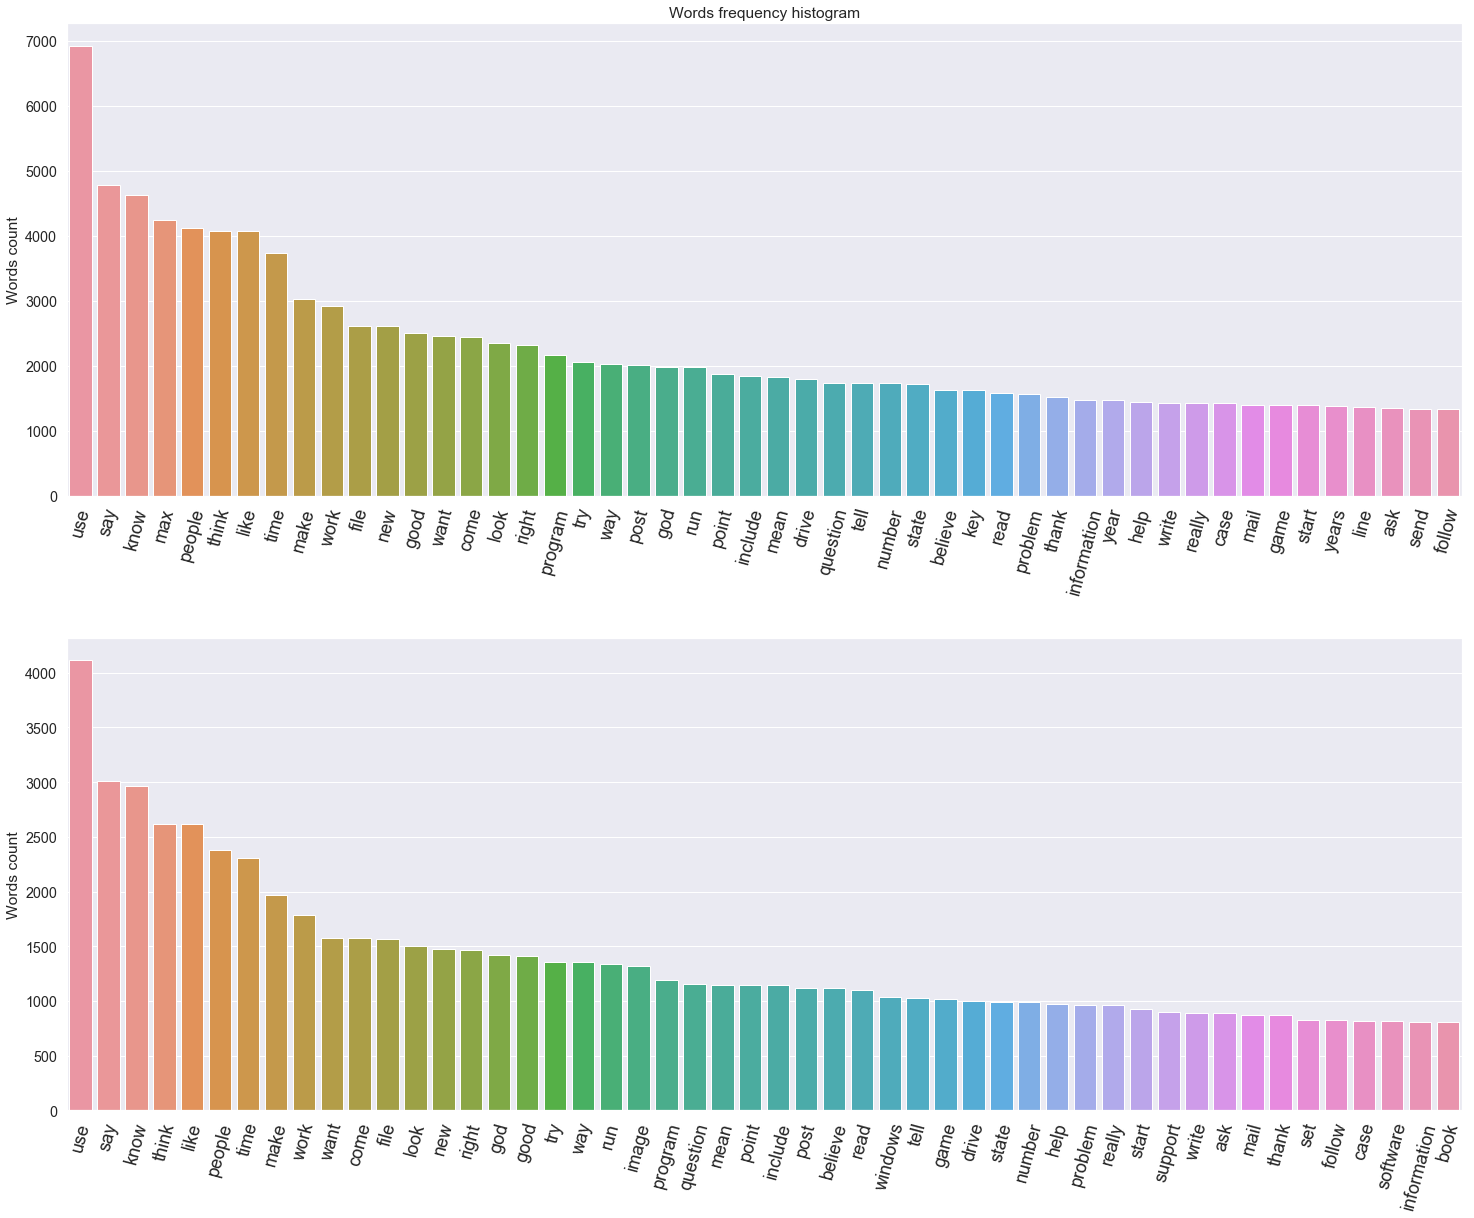

In [243]:
xs_train = [i[0] for i in train_top_words[:50]]
ys_train = [i[1] for i in train_top_words[:50]]

xs_test = [i[0] for i in test_top_words[:50]]
ys_test = [i[1] for i in test_top_words[:50]]

plt.figure(figsize=(25,20))
plt.subplot(2,1,1)
sns.barplot(x = xs_train, y = ys_train)
plt.ylabel('Words count');
plt.title("Words frequency histogram");
plt.xticks(rotation=75,fontsize = 18)
plt.subplots_adjust(hspace=0.3)
plt.subplot(2,1,2)
sns.barplot(x = xs_test, y = ys_test)
plt.ylabel('Words count');
plt.xticks(rotation=75,fontsize = 18)
plt.show();

##### Words cloud.

In [244]:
'''indices = np.argsort(vectorizer.idf_)[::-1] #
features = vectorizer.get_feature_names()
top_n = 15
top_features = [features[i] for i in indices[:top_n]]
print (top_features)''';

In [245]:
'''from collections import defaultdict

features_by_gram = defaultdict(list)
for f, w in zip(vectorizer.get_feature_names(), vectorizer.idf_):
    features_by_gram[len(f.split(' '))].append((f, w))

top_n = 15

for gram, features in features_by_gram.items():
    top_features = sorted(features, key=lambda x: x[1], reverse=True)[:top_n]
    top_features = [f[0] for f in top_features]
    print ('{}-gram top:'.format(gram), top_features)''';

 The higher the numerical weight value, the rarer the term. The smaller the weight, the more common the term.

In [246]:
'''#test block
indices = np.argsort(vectorizer.idf_)[::-1] # The inverse document frequency (IDF) vector, -1 if we want biggest first tf-idf weight
features = vectorizer.get_feature_names() #



np.sort(vectorizer.idf_)[::1]

indices

features[1604549]

#voc_dict = dict(zip(features,indices))
voc_dict = [features[i] for i in indices]
#voc_dict''';

In [247]:
'''from itertools import islice

def take(n, iterable):
    #"Return first n items of the iterable as a list"
    return dict(islice(iterable, n))

n_items = take(5, gg.items())

n_items''';

Some work with tf-idf vocabulary to get most used word(lowest tf-idf score).

In [248]:
train_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
train_dict =  dict(sorted(train_dict.items(), key=lambda kv: kv[1]))
# sort in descending order, most freq words first, rare words with big weight in the end

In [249]:
inverse_dict = {}
for k, v in train_dict.items():
    inverse_dict[k] = 1/int(v)
#inverse_dict    

In [250]:
def create_wc(freq_text, n_words):
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', max_words=n_words,
            stopwords = StopWords,width=1600, height=800)

    # Generate and plot wordcloud
    plt.figure(figsize =[14,7])
    plt.imshow(wc.generate_from_frequencies(frequencies=freq_text))
    plt.axis('off')
    plt.show()

TF-IDF set

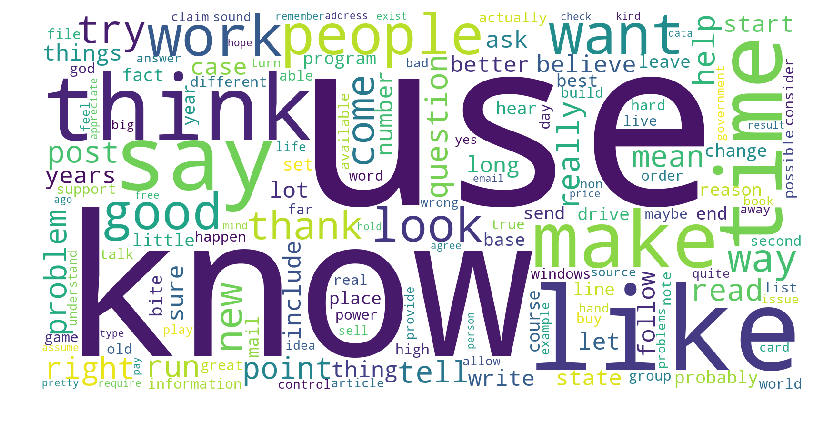

In [251]:
create_wc(inverse_dict,150)
del inverse_dict, train_dict

Count vectorizer train set

In [252]:
train_top_words_test = dict(train_top_words)
test_top_words_test = dict(test_top_words)

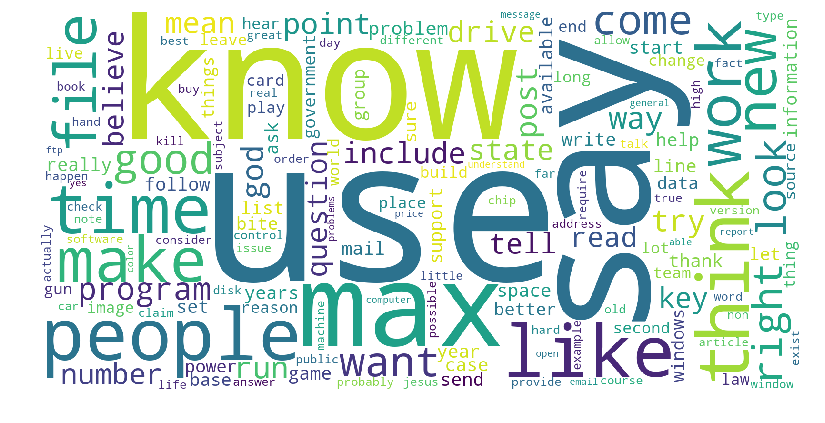

In [253]:
create_wc(train_top_words_test,150)

Count vectorizer test set

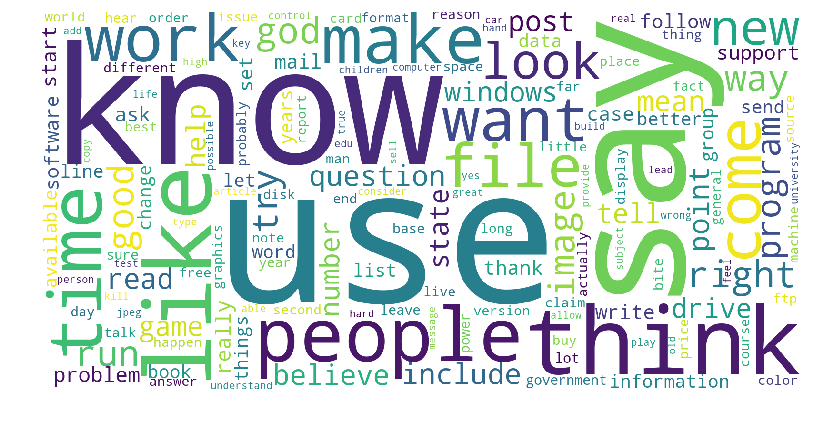

In [254]:
create_wc(test_top_words_test,150)
del train_top_words_test,test_top_words_test

Dimension reduction and visualization:
TruncatedSVD -> T-SNE or UMAP.

-- Попробуем выделить структуру при помощи TruncatedSVD.

In [264]:
svd = TruncatedSVD(n_components=2000, n_iter=15, random_state=seed)#,algorithm='arpack' can get better result,but time...

In [265]:
%%time
svd.fit(vectorised_train_documents)

Wall time: 1min 43s


TruncatedSVD(algorithm='randomized', n_components=2000, n_iter=15,
       random_state=321, tol=0.0)

In [266]:
print(svd.explained_variance_ratio_.sum())

0.6910152781087295


In [267]:
print(svd.explained_variance_.sum())

0.6820606343636695


In [268]:
svd_vect_train_documents = svd.transform(vectorised_train_documents)

svd_vect_test_documents = svd.transform(vectorised_test_documents)

In [269]:
svd_vect_train_documents.shape

(10975, 2000)

In [270]:
svd_vect_test_documents.shape

(7288, 2000)

#### T-SNE Test.

In [ ]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
tsne = TSNE(n_components=9, verbose=1, perplexity=50, n_iter=300,learning_rate = 100,method = 'exact')
tsne_results = tsne.fit_transform(svd_vect_train_documents)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:

df_tsne = pd.DataFrame(tsne_results.copy())
df_tsne['x_tsne'] = tsne_results[:,0]
df_tsne['y_tsne'] = tsne_results[:,1]

sns.lmplot(x='x_tsne', y='y_tsne',data = df_tsne)


#### UMAP Tests.

In [271]:
min_distances = [0.001,0.01,0.1,0.3] #bigger -> scattered
metrics = ['euclidean']#,'minkowski']
n_neighbors = [9]#[7,9,13] 
reducer = umap.UMAP(random_state=seed,n_neighbors=13, min_dist=0.3,metric='minkowski')
reducer

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='minkowski',
   metric_kwds=None, min_dist=0.3, n_components=2, n_epochs=None,
   n_neighbors=13, negative_sample_rate=5, random_state=321,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

9 euclidean 0.001


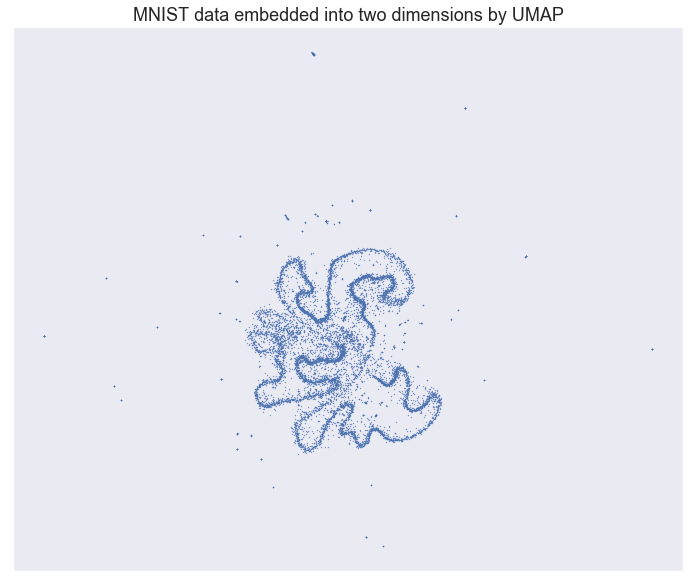

9 euclidean 0.01


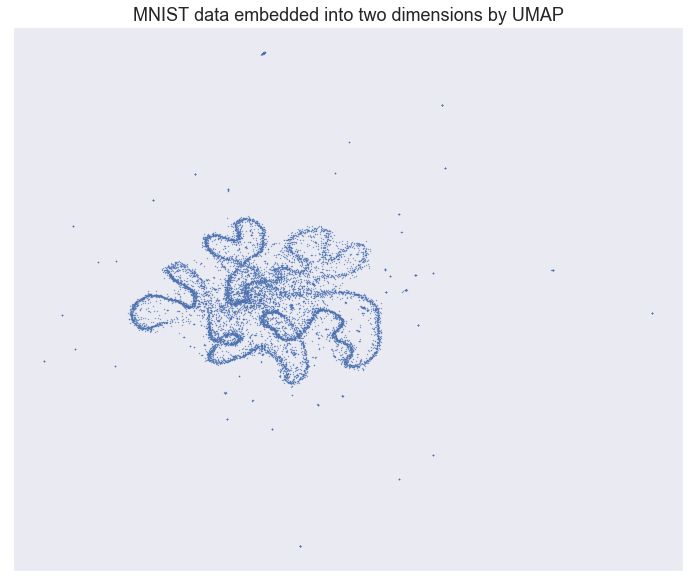

9 euclidean 0.1


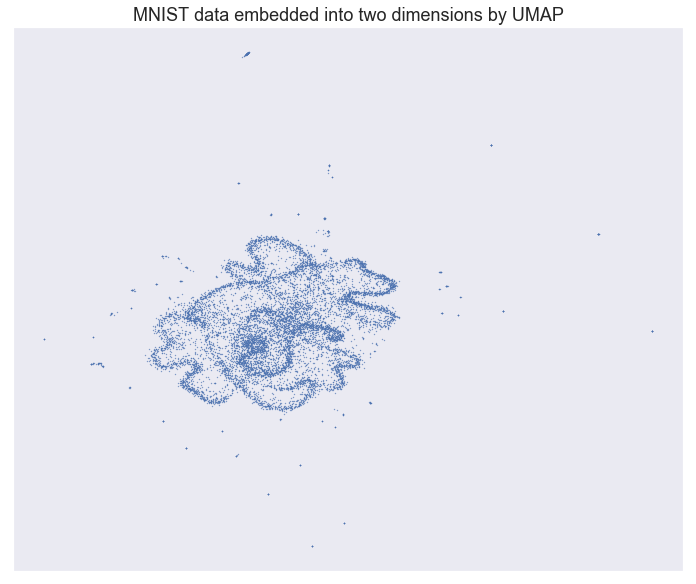

9 euclidean 0.3


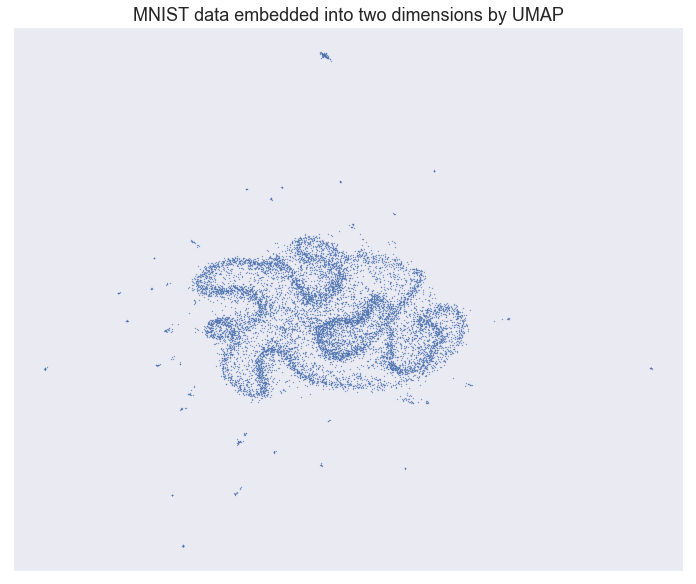

In [273]:
for n_nb in n_neighbors:
    reducer.n_neighbors = n_nb
    for m in metrics:
        reducer.metric = m
        for m_d in min_distances:
            print (n_nb, m, m_d)
            reducer.min_dist = m_d
            embedding = reducer.fit_transform(svd_vect_train_documents)
            fig, ax = plt.subplots(figsize=(12, 10))
            plt.scatter(
            embedding[:, 0], embedding[:, 1],  cmap="Spectral", s=0.1        )#c=mnist.target,
            plt.setp(ax, xticks=[], yticks=[])
            plt.title("MNIST data embedded into two dimensions by UMAP", fontsize=18)
            plt.show()
            

9 euclidean 0.001


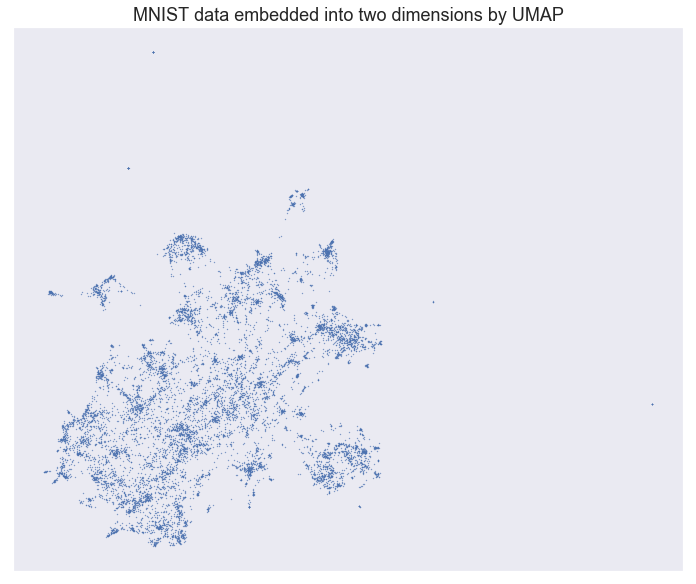

9 euclidean 0.01


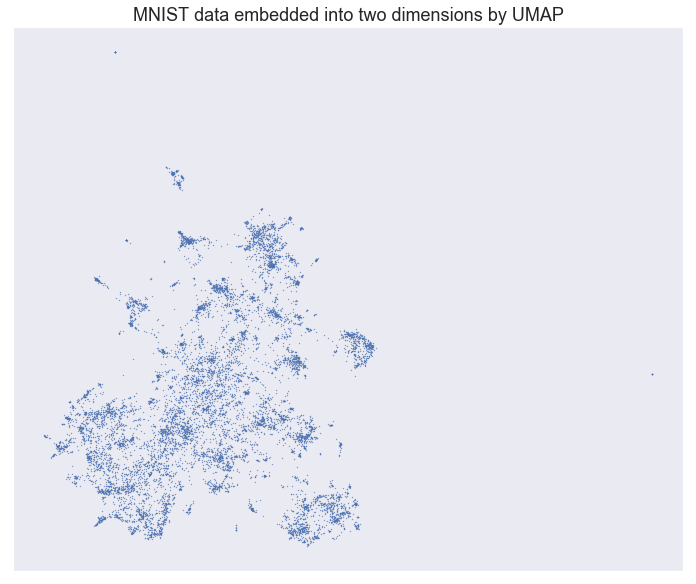

9 euclidean 0.1


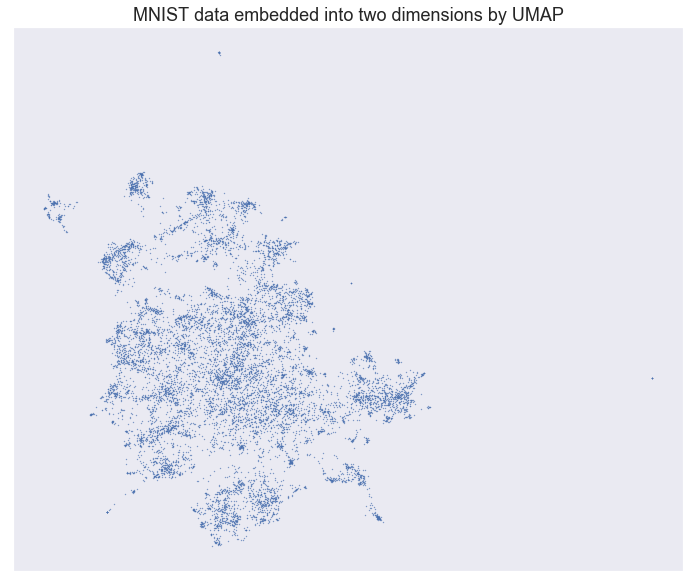

9 euclidean 0.3


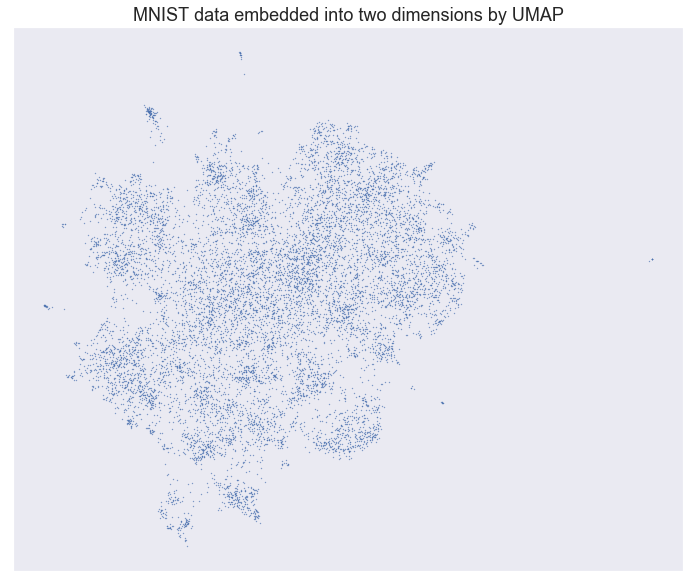

In [272]:
for n_nb in n_neighbors:
    reducer.n_neighbors = n_nb
    for m in metrics:
        reducer.metric = m
        for m_d in min_distances:
            print (n_nb, m, m_d)
            reducer.min_dist = m_d
            embedding = reducer.fit_transform(vectorised_train_documents)
            fig, ax = plt.subplots(figsize=(12, 10))
            plt.scatter(
            embedding[:, 0], embedding[:, 1],  cmap="Spectral", s=0.1        )#c=mnist.target,
            plt.setp(ax, xticks=[], yticks=[])
            plt.title("MNIST data embedded into two dimensions by UMAP", fontsize=18)
            plt.show()
            

#### Kmeans and DBSCAN.

Зададим параметры.

In [287]:
ss = StandardScaler(with_mean=False)

ss.fit(vectorised_train_documents)

vectorised_train_documents_scaled = ss.transform(vectorised_train_documents)
vectorised_test_documents_scaled = ss.transform(vectorised_test_documents)

In [325]:
k_clusters = 7 # Number of Centroids, correspond to amount high level topics
model = KMeans(n_clusters=k_clusters, max_iter=100, 
               n_init=15, n_jobs=-1,
               init = 'random',precompute_distances = 'auto') #init ='k-means++'

Масштабируем входные данные.

In [326]:
%%time
model.fit(vectorised_train_documents_scaled)

Wall time: 34.5 s


KMeans(algorithm='auto', copy_x=True, init='random', max_iter=100,
    n_clusters=7, n_init=15, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [327]:
def bench_k_means(estimator, name, data, labels,sample_size):
    print(82 * '_')
    print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
    t0 = time()
    #estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             homogeneity_score(labels, estimator.labels_),
             completeness_score(labels, estimator.labels_),
             v_measure_score(labels, estimator.labels_),
             adjusted_rand_score(labels, estimator.labels_),
             adjusted_mutual_info_score(labels,  estimator.labels_),
             silhouette_score(data, estimator.labels_,
                                      metric='euclidean')#, sample_size=sample_size)
            )
         )

In [328]:
bench_k_means(model,"kmeans" ,vectorised_train_documents_scaled, y_train,7)

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette


C:\Anaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


kmeans   	0.00s	173084680	0.057	0.260	0.094	0.041	0.057	-0.000


In [329]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(k_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print


Top terms per cluster:
Cluster 0:
 1945
 fiscal
 effectiveness
 respectively
 sherzer
 1915
 efforts
 seven
 stable
 methodology
Cluster 1:
 heatsink
 cooler
 741
 crystals
 enthusiasts
 bauer
 amplifiers
 cpu
 33mhz
 locally
Cluster 2:
 use
 like
 know
 think
 time
 make
 look
 work
 good
 thank
Cluster 3:
 armenian
 armenians
 armenia
 argic
 genocide
 karabakh
 turkish
 azerbaijan
 turks
 1914
Cluster 4:
 eece
 unm
 khoros
 visuals
 530
 commerical
 277
 505
 508
 precision
Cluster 5:
 god
 people
 jesus
 say
 christ
 believe
 fact
 faith
 state
 bible
Cluster 6:
 rle
 vgalogo
 lgo
 logo
 supercharge
 specially
 uuencoded
 com
 startup
 robbins


In [330]:
#y_pred = model.predict(vectorised_train_documents)
centers = model.cluster_centers_
transf = model.transform(vectorised_train_documents_scaled)

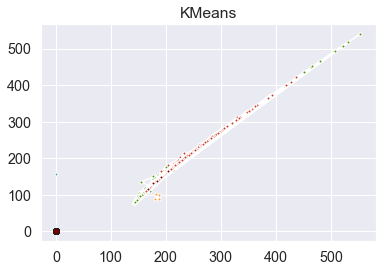

In [331]:
k_means_labels = model.labels_
k_means_cluster_centers = model.cluster_centers_

X = transf
colors = ['#4EACC5', '#FF9C34', '#4E9A06','#ce3d2b','#800000','#ce3d2b','#800000']

plt.figure()
#plt.hold(True)
for k, col in zip(range(k_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
plt.title('KMeans')    
plt.grid(True)
plt.show()

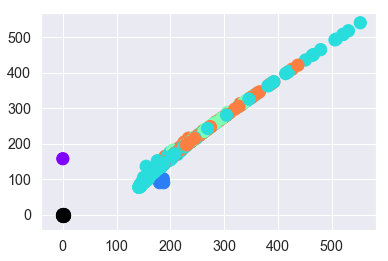

In [332]:
plt.scatter(transf[:,0],transf[:,1], c=model.labels_, cmap='rainbow',s=150)

plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

#### DBSCAN.

In [491]:
clusterer = DBSCAN(n_jobs=-1, eps=0.7, metric = 'cosine',min_samples=17)

#eps=0.7,metric='euclidean', min_samples=5, 

In [492]:
clusterer
# tune eps, leaf_size, metric?

DBSCAN(algorithm='auto', eps=0.7, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=17, n_jobs=-1, p=None)

In [493]:
vectorised_train_documents_scaled.shape

(10975, 15819)

In [494]:
vectorised_test_documents_scaled.shape

(7288, 15819)

In [495]:
svd_vect_train_documents.shape

(10975, 2000)

In [496]:
%%time
clusterer.fit(vectorised_train_documents) 
#clusterer.fit(vectorised_test_documents)

Wall time: 7.41 s


DBSCAN(algorithm='auto', eps=0.7, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=17, n_jobs=-1, p=None)

In [497]:
labels = clusterer.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [498]:
n_noise_

10746

In [499]:
n_clusters_

7

#### Topic modelling.

#### LDA from Gensim

In [506]:
%%time
#fit lda
num_topics=7 
passes=20
X = vectorised_train_documents
vocab = vectorizer.get_feature_names()
lda = LdaModel(matutils.Sparse2Corpus(X.T), num_topics=num_topics,
         passes=passes,
         id2word=dict([(i, s) for i, s in enumerate(vocab)]))

Wall time: 1min 1s


In [507]:
def print_topics(lda, vocab, n=10):
    """ Print the top words for each topic. """
    topics = lda.print_topics(num_topics=-1, num_words=n)
    for topic in topics:
        print(topic)

In [508]:
print_topics(lda, vocab)

(0, '0.005*"quadra" + 0.003*"powerbook" + 0.003*"1024x768" + 0.003*"viewer" + 0.003*"nope" + 0.002*"24x" + 0.002*"mpeg" + 0.002*"800x600" + 0.002*"900" + 0.002*"seagate"')
(1, '0.007*"god" + 0.005*"people" + 0.005*"say" + 0.003*"believe" + 0.003*"jesus" + 0.003*"think" + 0.003*"mean" + 0.003*"bible" + 0.003*"christian" + 0.003*"life"')
(2, '0.005*"gordon" + 0.005*"surrender" + 0.005*"intellect" + 0.005*"shameful" + 0.005*"chastity" + 0.005*"n3jxp" + 0.004*"skepticism" + 0.004*"bank" + 0.003*"soon" + 0.003*"650"')
(3, '0.005*"use" + 0.004*"know" + 0.004*"like" + 0.003*"thank" + 0.003*"time" + 0.003*"work" + 0.003*"think" + 0.003*"look" + 0.003*"want" + 0.003*"new"')
(4, '0.002*"moto" + 0.002*"candida" + 0.002*"68070" + 0.002*"esdi" + 0.002*"coprocessor" + 0.002*"detector" + 0.002*"dock" + 0.001*"smartdrv" + 0.001*"subaru" + 0.001*"winmarks"')
(5, '0.010*"game" + 0.008*"team" + 0.005*"play" + 0.005*"season" + 0.004*"players" + 0.004*"win" + 0.004*"year" + 0.004*"league" + 0.004*"hockey" 

pyLDAvis visualisation

In [525]:
import pyLDAvis.gensim
from gensim import corpora, models, similarities

In [556]:
from gensim.corpora.dictionary import Dictionary
corpus_vect_gensim = matutils.Sparse2Corpus(X.T)
dictionary = Dictionary.from_corpus(corpus_vect_gensim,
                                    dict([(i, s) for i, s in enumerate(vocab)]))

In [557]:
corpus = matutils.Sparse2Corpus(X.T)

#dictionary = #corpora.Dictionary.load(vectorised_train_documents)

lda = lda

In [558]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

C:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.257327 -0.090422       1        1  60.946911
1     -0.115795  0.190197       2        1  14.491834
6      0.170206  0.056608       3        1   9.269341
5      0.082945 -0.107086       4        1   7.150452
2      0.047025 -0.018925       5        1   3.000836
4      0.035802 -0.015777       6        1   2.584992
0      0.037144 -0.014596       7        1   2.555633, topic_info=      Category        Freq        Term       Total  loglift  logprob
term                                                                
6484   Default   61.000000        game   61.000000  30.0000  30.0000
6693   Default   62.000000         god   62.000000  29.0000  29.0000
10801  Default  119.000000      people  119.000000  28.0000  28.0000
12641  Default  134.000000         say  134.000000  27.0000  27.0000
15744  Default   60.000000        year   60.000000  26.0000  26.0000
14087  Default   41.000000        team   41.000000  25.0000  25.0000
11047  Default   44.000000        play   44.000000  24.0000  24.0000
15443  Default   35.000000         win   35.000000  23.0000  23.0000
13327  Default   26.000000        soon   26.000000  22.0000  22.0000
2359   Default   20.000000        bank   20.000000  21.0000  21.0000
2505   Default   69.000000     believe   69.000000  20.0000  20.0000
14263  Default  146.000000       think  146.000000  19.0000  19.0000
12748  Default   22.000000      season   22.000000  18.0000  18.0000
9230   Default   77.000000        mean   77.000000  17.0000  17.0000
8166   Default   30.000000       jesus   30.000000  16.0000  16.0000
5946   Default   23.000000         fan   23.000000  15.0000  15.0000
11050  Default   19.000000     players   19.000000  14.0000  14.0000
7200   Default   24.000000         hit   24.000000  13.0000  13.0000
8704   Default   37.000000        life   37.000000  12.0000  12.0000
6721   Default   13.000000      gordon   13.000000  11.0000  11.0000
8576   Default   18.000000      league   18.000000  10.0000  10.0000
2578   Default   25.000000       bible   25.000000   9.0000   9.0000
15529  Default   42.000000        word   42.000000   8.0000   8.0000
3456   Default   43.000000       claim   43.000000   7.0000   7.0000
3396   Default   27.000000   christian   27.000000   6.0000   6.0000
7220   Default   17.000000      hockey   17.000000   5.0000   5.0000
12695  Default   17.000000       score   17.000000   4.0000   4.0000
14941  Default  184.000000         use  184.000000   3.0000   3.0000
14212  Default  122.000000       thank  122.000000   2.0000   2.0000
2397   Default   19.000000    baseball   19.000000   1.0000   1.0000
...        ...         ...         ...         ...      ...      ...
1071    Topic7    3.416369     800x600    4.055027   3.4955  -6.1532
6361    Topic7    3.115962    freewill    3.754983   3.4803  -6.2453
12741   Topic7    3.118622     seagate    3.758550   3.4802  -6.2444
116     Topic7    3.087084   1280x1024    3.724180   3.4793  -6.2546
4346    Topic7    3.002891       cview    3.639194   3.4747  -6.2822
11683   Topic7    2.918401   quicktime    3.556984   3.4690  -6.3108
13844   Topic7    2.926162     sunrise    3.567139   3.4688  -6.3081
11718   Topic7    2.838307        rack    3.496327   3.4584  -6.3386
10751   Topic7    2.686788         pcx    3.337667   3.4499  -6.3935
578     Topic7    2.593353       33mhz    3.233149   3.4464  -6.4288
9412    Topic7    2.521648    migraine    3.169980   3.4381  -6.4569
8018    Topic7    2.435153         ipx    3.075614   3.4334  -6.4918
3883    Topic7    2.276436      conner    2.913907   3.4200  -6.5592
11976   Topic7    2.261629      refund    2.903033   3.4172  -6.5657
13846   Topic7    2.280906      sunset    2.938321   3.4136  -6.5572
2496    Topic7    2.201499         bel    2.847128   3.4097  -6.5927
11137   Topic7    2.057994     pontiac    2.694911   3.3972  -6.6601
4901    Topic7    2.0

In [550]:
def gensim_output(modelfile, corpusfile, dictionaryfile): 
    """Displaying gensim topic models"""
    ## Load files from "gensim_modeling"
    corpus = corpora.MmCorpus(corpusfile)
    dictionary = corpora.Dictionary.load(dictionaryfile) # for pyLDAvis
    myldamodel = models.ldamodel.LdaModel.load(modelfile)    

    ## Interactive visualisation
    import pyLDAvis.gensim
    vis = pyLDAvis.gensim.prepare(myldamodel, corpus, dictionary)
    pyLDAvis.display(vis)

In [552]:
#gensim_output(lda, vectorised_train_documents, vocab)

In [511]:
pyLDAvis.sklearn.prepare(lda, vectorised_train_documents, vectorizer)

AttributeError: 'LdaModel' object has no attribute 'components_'

#### difference between clustering, dimension reduction and topic modeling.

Кластеризация - 

Сокращение размерности - 

Тематическое моделирование - процесс одновременной кластеризации текстов и слов по одному и тому же множеству кластеров, называемых темами. 

Обычно выполняется нечёткая кластеризация, когда документ/слово может принадлежать нескольким темам.

По сути, мы пытаемся по tf-idf скору построить вероятностное распределение на множестве тем.

!!! to read !!!

- http://www.machinelearning.ru/wiki/images/f/f7/VMK_NLP_TM.pdf

- http://www.ispras.ru/proceedings/docs/2012/23/isp_23_2012_215.pdf

- https://iksinc.online/2016/05/16/topic-modeling-and-document-clustering-whats-the-difference/

- https://people.cs.umass.edu/~brenocon/inlp2014/lectures/22-tm.pdf

#### Appendix

Функция удаления пустых строк в numpy sparce matrix.

In [751]:
def remove_zero_tf_idf(Xtr, min_tfidf=0.04):
    D = Xtr.toarray() # convert to dense if you want
    D = Xtr
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0) # find features that are 0 in all documents
    D = np.delete(D, np.where(tfidf_means == 0)[0], axis=1) # delete them from the matrix
    return D

In [129]:
def show_most_informative_features(vectorizer, clf, n=20):
    aa = []
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t% 15s\t\t%.4f\t% 15s" % (coef_1, fn_1, coef_2, fn_2))
        aa.append(fn_1)
        
    #return aa

In [130]:
show_most_informative_features(vectorizer, clf, 10)

	-1.9377	     christians		2.9040	        atheism
	-1.2623	         christ		2.7894	          motto
	-1.2045	           want		2.6477	          nanci
	-1.1776	      christian		2.5821	      enlighten
	-1.1252	         heaven		2.5004	       religion
	-1.0873	          order		2.3586	          bobby
	-1.0545	          truth		2.3552	        coutesy
	-1.0445	            ask		2.3106	           loan
	-1.0434	      scripture		2.2638	        islamic
	-1.0388	      authority		2.2190	            bsa
